<a id="top"></a>
# Classifying flaring stars with stella: a convolutional neural network for TESS
 
## Learning Goals

**In this tutorial, you will see an example of building, compiling, and training a CNN to classify astronomical data in vector form.**
By the end of this tutorial you will have a working example of a simple Convolutional Neural Network (CNN) in `Keras`.

## Introduction
CNNs are a class of machine learning (ML) algorithms that can extract information from data. In this notebook, you will walk through the basic steps of applying a CNN to data:
1. Load the data and visualize a sample of the data.
2. Build a CNN in `Keras`.
3. Compile the CNN.
4. Train the CNN to perform a classification task.
5. Evaluate the CNN performance on test data with a confusion matrix.
6. Build a new, unlabeled dataset and apply the CNN.


CNNs can be applied to a wide range of vector analysis tasks, including classification and regression.
Here, we will build, compile, and train CNN to classify whether a star has undergone a flaring event from its observed Transiting Exoplanet Survey Satellite ([TESS](https://www.nasa.gov/tess-transiting-exoplanet-survey-satellite/)) 2-minute light curve, and where the flaring events are located within the time series.
This work is based on the model described in the [`stella`](https://ui.adsabs.harvard.edu/abs/2020JOSS....5.2347F/abstract) software package.

**NOTE:** *The [`stella` team has publicly-available code and documentation](https://adina.feinste.in/stella/) for demonstrating the architecture and optimal performance of this model, which we encourage you to check out!
The goal of this notebook is to step through the model building and training process.* 

## About this Notebook

**Author:**  
Claire Murray, Assistant Astronomer, cmurray1@stsci.edu
    
**Additional Contributors:**  
Yotam Cohen, STScI Staff Scientist, ycohen@stsci.edu

**Info:**  
This notebook is based on the [`stella`](https://ui.adsabs.harvard.edu/abs/2020JOSS....5.2347F/abstract) software package for the CNN used in ["Flare Statistics for Young Stars from a Convolutional Neural Network Analysis of TESS Data"](https://dx.doi.org/10.3847/1538-3881/abac0a), Adina D. Feinstein et al. Astronomical Journal, Volume 160, Issue 5, November 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.

**Published:** 2022-06-01

**Updated:** 2023-12-13

***

## Imports
This notebook uses the following:
- `numpy` to handle array functions
- `astropy` for accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` for building the CNN
- `sklearn` for model performance metrics
- `lightkurve.search` for extracting light curves

For other packages, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file

# plotting
import matplotlib.pyplot as plt

# keras
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense, Dropout, Conv1D, MaxPooling1D

# sklearn for performance metrics
from sklearn import metrics

# lightkurve
from lightkurve import search_lightcurve

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'notebook')

# set random seed for reproducibility 
np.random.seed(42)

2025-07-14 19:28:32.482052: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 19:28:32.513324: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-14 19:28:32.513355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-14 19:28:32.514429: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 19:28:32.519828: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 19:28:32.520318: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-07-14 19:28:33.270128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


## 1. Download the training data

Load the sample of TESS lightcurves (input vectors) and flare classifications (output labels) to be used to train the CNN.

The training set contains stars observed at 2-minute cadence in TESS Sectors 1 and 2, classified by hand and presented as a flare catalog by [Gunther et al. 2020](https://dx.doi.org/10.3847/1538-3881/ab5d3a).
The light curves are processed into examples of length 200 cadences, where each flaring event, if present, is located at the center of the example. The full sample of lightcurves contains 8694 positive classes (flare), and 35896 negative classes (no flare).
For this notebook, we will download a subset of this sample.
These data are described in [Feinstein et al. 2020](
https://dx.doi.org/10.3847/1538-3881/abac0a).

The CNN will be used to predict the presence of flaring events as a function of observing cadence.
The input to the CNN is a light curve (time, flux, and flux error) and the output is a "probability light curve", or probabilities (value between 0 and 1) that the measurement at each cadence is of a flaring event (1=flare, 0=no flare).
In other words, the CNN performs a **classification** task at each cadence.

In [2]:
%%time
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_stella_500.fits'
hdu = fits.open(download_file(file_url, cache=True))

CPU times: user 873 μs, sys: 965 μs, total: 1.84 ms
Wall time: 1.56 ms


The `stella` dataset includes training, test and validation lightcurves (input vectors) and flare labels (output labels).
For more on how these are constructed, see [Feinstein et al. 2020](https://dx.doi.org/10.3847/1538-3881/abac0a).
For our purposes (i.e., building the `stella` CNN from scratch to illustrate its structure and function), we first unpack the multi-extension table to isolate the training dataset and training labels, validation dataset and validation labels, and testing dataset and testing labels. 

In [3]:
train_data = hdu[1].data['train_data']
train_labels = hdu[1].data['train_labels']

test_data = hdu[2].data['test_data']
test_labels = hdu[2].data['test_labels']

val_data = hdu[3].data['val_data']
val_labels = hdu[3].data['val_labels']

To visualize the structure of the lightcurves in the training set, in the cell below we plot a random selection of examples. The resulting figure displays a grid of 16 light curves (flux as a function of time), one per panel. If a flare is detected in the light curve, it is colored red and the title of the panel is "Flare". If a flare is not detected in the light curve, it is colored black and the title of the panel is "Non-flare". 

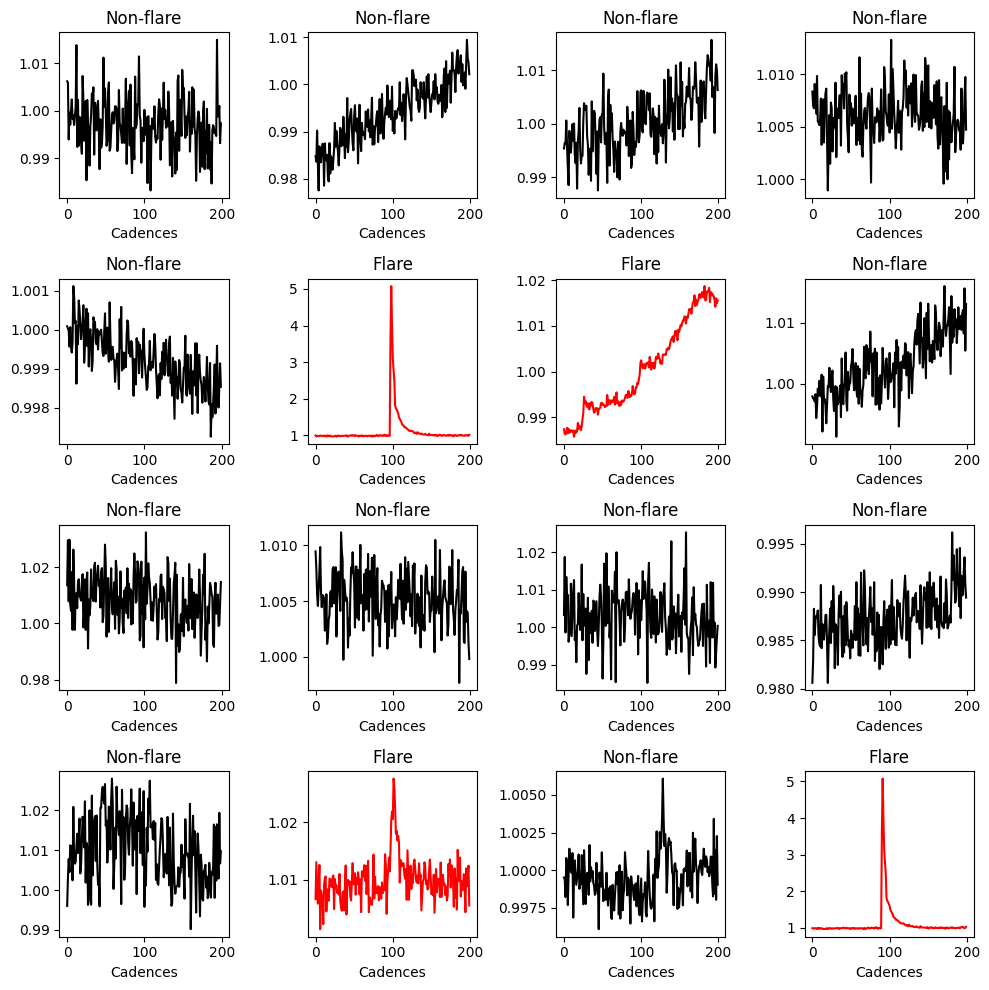

In [4]:
# select random image indices:
example_ids = np.random.choice(len(train_labels), 16)

# pull the lightcurves and labels for these selections
example_lightcurves = [train_data[j] for j in example_ids]
example_labels = [train_labels[j] for j in example_ids]


# initialize your figure
fig = plt.figure(figsize=(10, 10))

# loop through the randomly selected images and plot with labels
colors = {1: 'r', 0: 'k'}
titles = {1: 'Flare', 0: 'Non-flare'}
for i in range(len(example_ids)):
    plt.subplot(4, 4, i + 1)
    plt.plot(example_lightcurves[i], color=colors[example_labels[i]])
    plt.title(titles[example_labels[i]])
    plt.xlabel('Cadences')
    
plt.tight_layout()
plt.show()

## 2. Build a CNN in `Keras`

Here, we will build the CNN model described in [Feinstein et al. 2020](
https://dx.doi.org/10.3847/1538-3881/abac0a) and implemented in `stella` from scratch.

Further details about Conv1D, MaxPooling1D, BatchNormalization, Dropout, and Dense layers can be found in the [Keras Layers Documentation](https://keras.io/api/layers/).
Further details about the sigmoid and softmax activation function can be found in the [Keras Activation Function Documentation](https://keras.io/api/layers/activations/).

In [5]:
# ------------------------------------------------------------------------------
# generate the model architecture
# Written for Keras 2
# ------------------------------------------------------------------------------

seed = 2
np.random.seed(seed)

filter1 = 16
filter2 = 64
dense = 32
dropout = 0.1

# Define architecture for model
data_shape = np.shape(train_data)
input_shape = (np.shape(train_data)[1], 1)

x_in = Input(shape=input_shape)
c0 = Conv1D(7, filter1, activation='relu', padding='same', input_shape=input_shape)(x_in)
b0 = MaxPooling1D(pool_size=2)(c0)
d0 = Dropout(dropout)(b0)

c1 = Conv1D(3, filter2, activation='relu', padding='same')(d0)
b1 = MaxPooling1D(pool_size=2)(c1)
d1 = Dropout(dropout)(b1)


f = Flatten()(d1)
z0 = Dense(dense, activation='relu')(f)
d2 = Dropout(dropout)(z0)
y_out = Dense(1, activation='sigmoid')(d2)

cnn = Model(inputs=x_in, outputs=y_out)

## 3. Compile the CNN

Next, we compile the model.
As in [Feinstein et al. 2020](https://dx.doi.org/10.3847/1538-3881/abac0a), we select the Adam optimizer and the binary cross entropy loss function (as this is a binary classification problem).

You can learn more about [optimizers](https://keras.io/api/optimizers/) and more about [loss functions for regression tasks](https://keras.io/api/losses/) in the [Keras documentation](https://keras.io/).

In [6]:
# Compile Model
optimizer = 'adam'
fit_metrics = ['accuracy'] 
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)
cnn.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 200, 1)]          0         


 conv1d (Conv1D)             (None, 200, 7)            119       


 max_pooling1d (MaxPooling1  (None, 100, 7)            0         


 D)                                                              


 dropout (Dropout)           (None, 100, 7)            0         


 conv1d_1 (Conv1D)           (None, 100, 3)            1347      


 max_pooling1d_1 (MaxPoolin  (None, 50, 3)             0         


 g1D)                                                            


 dropout_1 (Dropout)         (None, 50, 3)             0         


 flatten (Flatten)           (None, 150)               0         


 dense (Dense)               (None, 32)                4832      


 dropout_2 (Dropout)         (None, 32)                0         


 dense_1 (Dense)             (None, 1)                 33        


Total params: 6331 (24.73 KB)


Trainable params: 6331 (24.73 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


## 4. Train the CNN to perform a classification task

We will start with training for 20 epochs, but this almost certainly won't be long enough to get great results.
Once you've run your model and evaluated the fit, you can come back here and run the next cell again for 100 epochs or longer.  

You can learn more about `fit` [here](https://keras.rstudio.com/reference/fit.html).

In [7]:
nb_epoch = 20
batch_size = 64
shuffle = True

# Train
history = cnn.fit(train_data, train_labels,
                  batch_size=batch_size, 
                  epochs=nb_epoch, 
                  validation_data=(val_data, val_labels), 
                  shuffle=shuffle,
                  verbose=True)

Epoch 1/20


 1/23 [>.............................] - ETA: 14s - loss: 0.6023 - accuracy: 0.7500

 7/23 [========>.....................] - ETA: 0s - loss: 0.6011 - accuracy: 0.7344 

14/23 [=================>............] - ETA: 0s - loss: 0.5914 - accuracy: 0.7377

21/23 [==========================>...] - ETA: 0s - loss: 0.5929 - accuracy: 0.7307

23/23 [==============================] - 1s 15ms/step - loss: 0.5918 - accuracy: 0.7309 - val_loss: 0.6040 - val_accuracy: 0.7088


Epoch 2/20


 1/23 [>.............................] - ETA: 0s - loss: 0.6206 - accuracy: 0.7031

 8/23 [=========>....................] - ETA: 0s - loss: 0.6101 - accuracy: 0.7129

15/23 [==================>...........] - ETA: 0s - loss: 0.6051 - accuracy: 0.7177

22/23 [===========================>..] - ETA: 0s - loss: 0.5907 - accuracy: 0.7301

23/23 [==============================] - 0s 9ms/step - loss: 0.5893 - accuracy: 0.7309 - val_loss: 0.6066 - val_accuracy: 0.7088


Epoch 3/20


 1/23 [>.............................] - ETA: 0s - loss: 0.5841 - accuracy: 0.7344

 8/23 [=========>....................] - ETA: 0s - loss: 0.5921 - accuracy: 0.7227

15/23 [==================>...........] - ETA: 0s - loss: 0.5882 - accuracy: 0.7302

22/23 [===========================>..] - ETA: 0s - loss: 0.5883 - accuracy: 0.7280

23/23 [==============================] - 0s 9ms/step - loss: 0.5851 - accuracy: 0.7309 - val_loss: 0.6025 - val_accuracy: 0.7088


Epoch 4/20


 1/23 [>.............................] - ETA: 0s - loss: 0.4241 - accuracy: 0.8750

 8/23 [=========>....................] - ETA: 0s - loss: 0.5976 - accuracy: 0.7246

15/23 [==================>...........] - ETA: 0s - loss: 0.5844 - accuracy: 0.7396

22/23 [===========================>..] - ETA: 0s - loss: 0.5851 - accuracy: 0.7351

23/23 [==============================] - 0s 9ms/step - loss: 0.5870 - accuracy: 0.7329 - val_loss: 0.5980 - val_accuracy: 0.7088


Epoch 5/20


 1/23 [>.............................] - ETA: 0s - loss: 0.5432 - accuracy: 0.7656

 8/23 [=========>....................] - ETA: 0s - loss: 0.5800 - accuracy: 0.7266

14/23 [=================>............] - ETA: 0s - loss: 0.5735 - accuracy: 0.7288

21/23 [==========================>...] - ETA: 0s - loss: 0.5689 - accuracy: 0.7359

23/23 [==============================] - 0s 9ms/step - loss: 0.5708 - accuracy: 0.7350 - val_loss: 0.5913 - val_accuracy: 0.7143


Epoch 6/20


 1/23 [>.............................] - ETA: 0s - loss: 0.5416 - accuracy: 0.7656

 7/23 [========>.....................] - ETA: 0s - loss: 0.5452 - accuracy: 0.7656

14/23 [=================>............] - ETA: 0s - loss: 0.5748 - accuracy: 0.7377

21/23 [==========================>...] - ETA: 0s - loss: 0.5702 - accuracy: 0.7411

23/23 [==============================] - 0s 9ms/step - loss: 0.5665 - accuracy: 0.7445 - val_loss: 0.5938 - val_accuracy: 0.7143


Epoch 7/20


 1/23 [>.............................] - ETA: 0s - loss: 0.5899 - accuracy: 0.7344

 8/23 [=========>....................] - ETA: 0s - loss: 0.5591 - accuracy: 0.7461

15/23 [==================>...........] - ETA: 0s - loss: 0.5565 - accuracy: 0.7521

22/23 [===========================>..] - ETA: 0s - loss: 0.5650 - accuracy: 0.7464

23/23 [==============================] - 0s 9ms/step - loss: 0.5637 - accuracy: 0.7480 - val_loss: 0.5809 - val_accuracy: 0.7198


Epoch 8/20


 1/23 [>.............................] - ETA: 0s - loss: 0.4900 - accuracy: 0.8438

 8/23 [=========>....................] - ETA: 0s - loss: 0.5639 - accuracy: 0.7461

15/23 [==================>...........] - ETA: 0s - loss: 0.5562 - accuracy: 0.7479

22/23 [===========================>..] - ETA: 0s - loss: 0.5497 - accuracy: 0.7514

23/23 [==============================] - 0s 9ms/step - loss: 0.5509 - accuracy: 0.7507 - val_loss: 0.5729 - val_accuracy: 0.7198


Epoch 9/20


 1/23 [>.............................] - ETA: 0s - loss: 0.5122 - accuracy: 0.7656

 8/23 [=========>....................] - ETA: 0s - loss: 0.5216 - accuracy: 0.7617

15/23 [==================>...........] - ETA: 0s - loss: 0.5327 - accuracy: 0.7573

22/23 [===========================>..] - ETA: 0s - loss: 0.5343 - accuracy: 0.7599

23/23 [==============================] - 0s 9ms/step - loss: 0.5387 - accuracy: 0.7568 - val_loss: 0.5760 - val_accuracy: 0.7198


Epoch 10/20


 1/23 [>.............................] - ETA: 0s - loss: 0.6568 - accuracy: 0.6562

 8/23 [=========>....................] - ETA: 0s - loss: 0.5225 - accuracy: 0.7754

15/23 [==================>...........] - ETA: 0s - loss: 0.5377 - accuracy: 0.7615

21/23 [==========================>...] - ETA: 0s - loss: 0.5396 - accuracy: 0.7597

23/23 [==============================] - 0s 9ms/step - loss: 0.5423 - accuracy: 0.7555 - val_loss: 0.5570 - val_accuracy: 0.7308


Epoch 11/20


 1/23 [>.............................] - ETA: 0s - loss: 0.4401 - accuracy: 0.8906

 8/23 [=========>....................] - ETA: 0s - loss: 0.5055 - accuracy: 0.7871

15/23 [==================>...........] - ETA: 0s - loss: 0.5160 - accuracy: 0.7760

22/23 [===========================>..] - ETA: 0s - loss: 0.5253 - accuracy: 0.7678

23/23 [==============================] - 0s 9ms/step - loss: 0.5272 - accuracy: 0.7671 - val_loss: 0.5466 - val_accuracy: 0.7308


Epoch 12/20


 1/23 [>.............................] - ETA: 0s - loss: 0.5444 - accuracy: 0.7812

 7/23 [========>.....................] - ETA: 0s - loss: 0.5179 - accuracy: 0.7679

14/23 [=================>............] - ETA: 0s - loss: 0.5263 - accuracy: 0.7600

21/23 [==========================>...] - ETA: 0s - loss: 0.5282 - accuracy: 0.7597

23/23 [==============================] - 0s 9ms/step - loss: 0.5262 - accuracy: 0.7616 - val_loss: 0.5449 - val_accuracy: 0.7308


Epoch 13/20


 1/23 [>.............................] - ETA: 0s - loss: 0.5902 - accuracy: 0.7031

 8/23 [=========>....................] - ETA: 0s - loss: 0.5323 - accuracy: 0.7578

15/23 [==================>...........] - ETA: 0s - loss: 0.5276 - accuracy: 0.7604

22/23 [===========================>..] - ETA: 0s - loss: 0.5145 - accuracy: 0.7663

23/23 [==============================] - 0s 9ms/step - loss: 0.5145 - accuracy: 0.7664 - val_loss: 0.5352 - val_accuracy: 0.7308


Epoch 14/20


 1/23 [>.............................] - ETA: 0s - loss: 0.5553 - accuracy: 0.7344

 8/23 [=========>....................] - ETA: 0s - loss: 0.5363 - accuracy: 0.7539

15/23 [==================>...........] - ETA: 0s - loss: 0.5161 - accuracy: 0.7781

22/23 [===========================>..] - ETA: 0s - loss: 0.5084 - accuracy: 0.7812

23/23 [==============================] - 0s 9ms/step - loss: 0.5083 - accuracy: 0.7814 - val_loss: 0.5304 - val_accuracy: 0.7363


Epoch 15/20


 1/23 [>.............................] - ETA: 0s - loss: 0.3766 - accuracy: 0.8750

 8/23 [=========>....................] - ETA: 0s - loss: 0.4746 - accuracy: 0.7969

14/23 [=================>............] - ETA: 0s - loss: 0.4784 - accuracy: 0.7924

21/23 [==========================>...] - ETA: 0s - loss: 0.4892 - accuracy: 0.7857

23/23 [==============================] - 0s 9ms/step - loss: 0.4896 - accuracy: 0.7855 - val_loss: 0.5122 - val_accuracy: 0.7637


Epoch 16/20


 1/23 [>.............................] - ETA: 0s - loss: 0.5002 - accuracy: 0.8125

 8/23 [=========>....................] - ETA: 0s - loss: 0.4934 - accuracy: 0.7852

15/23 [==================>...........] - ETA: 0s - loss: 0.4737 - accuracy: 0.7990

22/23 [===========================>..] - ETA: 0s - loss: 0.4831 - accuracy: 0.7912

23/23 [==============================] - 0s 9ms/step - loss: 0.4849 - accuracy: 0.7903 - val_loss: 0.5025 - val_accuracy: 0.7637


Epoch 17/20


 1/23 [>.............................] - ETA: 0s - loss: 0.5141 - accuracy: 0.7656

 8/23 [=========>....................] - ETA: 0s - loss: 0.5093 - accuracy: 0.7812

15/23 [==================>...........] - ETA: 0s - loss: 0.4912 - accuracy: 0.7917

22/23 [===========================>..] - ETA: 0s - loss: 0.4887 - accuracy: 0.7962

23/23 [==============================] - 0s 9ms/step - loss: 0.4855 - accuracy: 0.7985 - val_loss: 0.5023 - val_accuracy: 0.7637


Epoch 18/20


 1/23 [>.............................] - ETA: 0s - loss: 0.4848 - accuracy: 0.7656

 8/23 [=========>....................] - ETA: 0s - loss: 0.4294 - accuracy: 0.8203

15/23 [==================>...........] - ETA: 0s - loss: 0.4523 - accuracy: 0.8052

22/23 [===========================>..] - ETA: 0s - loss: 0.4594 - accuracy: 0.8011

23/23 [==============================] - 0s 9ms/step - loss: 0.4631 - accuracy: 0.7978 - val_loss: 0.4775 - val_accuracy: 0.7802


Epoch 19/20


 1/23 [>.............................] - ETA: 0s - loss: 0.4748 - accuracy: 0.8281

 8/23 [=========>....................] - ETA: 0s - loss: 0.4489 - accuracy: 0.8281

14/23 [=================>............] - ETA: 0s - loss: 0.4580 - accuracy: 0.8125

21/23 [==========================>...] - ETA: 0s - loss: 0.4547 - accuracy: 0.8147

23/23 [==============================] - 0s 9ms/step - loss: 0.4578 - accuracy: 0.8115 - val_loss: 0.4660 - val_accuracy: 0.7857


Epoch 20/20


 1/23 [>.............................] - ETA: 0s - loss: 0.3829 - accuracy: 0.8594

 8/23 [=========>....................] - ETA: 0s - loss: 0.4259 - accuracy: 0.8340

15/23 [==================>...........] - ETA: 0s - loss: 0.4431 - accuracy: 0.8167

22/23 [===========================>..] - ETA: 0s - loss: 0.4427 - accuracy: 0.8146

23/23 [==============================] - 0s 9ms/step - loss: 0.4459 - accuracy: 0.8128 - val_loss: 0.4523 - val_accuracy: 0.7857


In [8]:
# save the model to file
cnn_file = 'flare_model.h5'
cnn.save(cnn_file)

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 5. Test the CNN performance 

Apply the CNN to predict flares on the "test" set, not used for training or validating the CNN, and evaluate the performance using a confusion matrix.
See the documentation from [sklearn on confusion matrices](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for more information.
The code for generating and plotting the confusion matrix below was adapted from the application by [Ciprijanovic et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26C....3200390C/abstract) for [DeepMerge](https://github.com/deepskies/deepmerge-public).

In [9]:
def plot_confusion_matrix(cnn, input_data, input_labels):
    
    # Compute flare predictions for the test dataset
    predictions = cnn.predict(input_data)

    # Convert to binary classification 
    predictions = (predictions > 0.5).astype('int32') 
    
    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1])
    cm = cm.astype('float')

    # Normalize the confusion matrix results. 
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm, cmap='binary_r')

    plt.title('Confusion matrix', y=1.08)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Flare', 'No Flare'])
    
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Flare', 'No Flare'])

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt), 
                    ha="center", va="center", color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()

In the cell below, we execute the code to plot the confusion matrix. The result is a 2x2 grid of squares, with the predicted classes ("Flare" and "No Flare") on the x-axis and the true classes ("Flare" and "No Flare") on the y-axis. Numbers at the center of each panel quantify the fraction of results in each true class that are found in each predicted class (e.g., the fraction of true flares which are predicted to be flares), so that the numbers in each horizontal row sum to 1.0. The color of each panel also corresponds to these fractions and range from white to black, where white is equal to 1.0 and black is equal to 0. 

In this example, the values in the top row are 1.0 and 0.0, meaning that 100% of true flares are predicted to be flares, and 0% of true flares are predicted to be no flare. The values in the bottom row are 0.7 and 0.3, meaning that 70% of the true not flares are predicted to be flares, and 30% of the true not flares are predicted to be not flares. 

1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 2ms/step


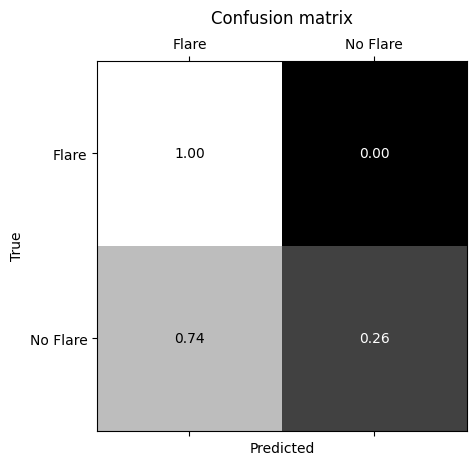

In [10]:
plot_confusion_matrix(cnn, test_data, test_labels)

### FAQ

- **The results don't look great... why?** From the confusion matrix in Section 5, when faced with the test dataset (i.e., data not used for training or validation), the model predicts a large fraction of false positive flare events, and consequently not enough true negative flare events).
The published models from [Feinstein et al. 2020](https://dx.doi.org/10.3847/1538-3881/abac0a) perform *much better*, and the confusion matrix **should look more like the results shown below**.
We note that in this notebook we are using a subset of the available training data, and we are training the model for only a subset of the optimal number of epochs for space and time considerations, but you are welcome to augment these restrictions, and as always check out [the `stella` repository](https://adina.feinste.in/stella/) for more information!

In the cell below, we execute the code to plot the confusion matrix. The result is a 2x2 grid of squares, with the predicted classes ("Flare" and "No Flare") on the x-axis and the true classes ("Flare" and "No Flare") on the y-axis. Numbers at the center of each panel quantify the fraction of results in each true class that are found in each predicted class (e.g., the fraction of true flares which are predicted to be flares), so that the numbers in each horizontal row sum to 1.0. The color of each panel also corresponds to these fractions and range from white to black, where white is equal to 1.0 and black is equal to 0. 

In this example (which uses the trained model from Fein, the values in the top row are 0.98 and 0.02, meaning that % of true flares are predicted to be flares, and 0% of true flares are predicted to be no flare. The values in the bottom row are 0.7 and 0.3, meaning that 70% of the true not flares are predicted to be flares, and 30% of the true not flares are predicted to be not flares. 

1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 2ms/step


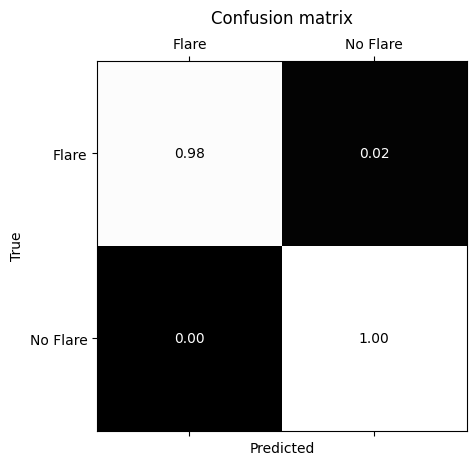

In [11]:
file_url = 'https://archive.stsci.edu/hlsps/stella/hlsp_stella_tess_ensemblemodel_s042_tess_v0.1.0_cnn.h5'
pretrained_model = load_model(download_file(file_url, cache=True, show_progress=True))

plot_confusion_matrix(pretrained_model, test_data, test_labels)

- **Can I improve the model by increasing the number of epochs its training for?**
We only trained for 20 epochs, which is many fewer than the published model.
Go back to Section 4 ("Train the CNN to perform a classification task") and increase the number of epochs to 100 (or more!) and train again.
Does your model perform better?
Your results may look better/worse/different from the published results due to the stochastic nature of training. 


- **Can I try a different model?  I think the results could be improved.**
Yes! You can try adding layers, swapping out the max pooling, changing the activation functions, swapping out the loss function, or trying a different optimizer or learning rate.
Experiment and see what model changes give the best results.
You should be aware: when you start training again, you pick up where your model left off.
If you want to "reset" your model to epoch 0 and random weights, you should run the cells to make and compile the model again.


- **I want to test my model on my training data!**
No.
You will convince yourself that your results are much better than they actually are.
Always keep your training, validation, and testing sets completely separate!   

### Extensions/Exercises

- **Is the model "overfitting"?**
Using the results of the model's `history` (saved as a result of the model training process), investigate the behavior of the training and validation losses and accuracies as a function of training epoch.
Make a plot or two!
How do the training and validation losses compare?
How do the training and validation accuracies compare?
If the loss for the validation set is higher than for the training set (and conversely, the accuracy for the validation set is lower than for the training set), the model may be suffering from [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).


- **Try applying this model to a new dataset**
You can pre-process your own 2-minute cadence TESS light curves and predict flares. 
An example workflow is shown below: 

## 6. Predict flares in a new dataset 

In this step, we will download light curves directly from TESS, pre-process them for input to the CNN, and predict flares.
The sample is a set of bright M dwarfs not featured in the training/validation/tests datasets.

First select a sample of sources by their ids numbers:

In [12]:
ticids = ['120461526', '278779899', '139754153', '273418879', '52121469', '188580272', '394015919', '402104884']

In [13]:
# for all the selected targets, pull the available lightcurves using the lightkurve package
lcs = []
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=[1, 2], author='SPOC')
    lc = lc.download_all()
    lcs.append(lc)

Here we define functions (based on `stella`) which pre-process the light curves ("identify gaps") and apply a pre-trained model to predict flares ("stella_predict")

In [14]:
def identify_gaps(t, cad_pad):
    """
    Identifies which cadences can be predicted on given
    locations of gaps in the data. Will always stay 
    cadences/2 away from the gaps.

    Returns lists of good indices to predict on.
    """

    # SETS ALL CADENCES AVAILABLE
    all_inds = np.arange(0, len(t), 1, dtype=int)

    # REMOVES BEGINNING AND ENDS
    bad_inds = np.arange(0, cad_pad, 1, dtype=int)
    bad_inds = np.append(bad_inds, np.arange(len(t)-cad_pad,
                                             len(t), 1, dtype=int))

    diff = np.diff(t)
    med, std = np.nanmedian(diff), np.nanstd(diff)

    bad = np.where(np.abs(diff) >= med + 1.5*std)[0]
    for b in bad:
        bad_inds = np.append(bad_inds, np.arange(b-cad_pad,
                                                 b+cad_pad,
                                                 1, dtype=int))
    bad_inds = np.sort(bad_inds)
    return np.delete(all_inds, bad_inds)

In [15]:
def stella_predict(modelname, time, flux, err):
    """
    Loads pre-trained model and predicts 
    flares in input light curves.
    
    Returns array of flare predictions
    """
    # load model               
    model = load_model(modelname)

    # GETS REQUIRED INPUT SHAPE FROM MODEL
    cadences = model.input.shape[1]
    cad_pad = cadences/2

    # normalize flux
    lc = flux / np.nanmedian(flux)  

    # identify good channels
    good_inds = identify_gaps(time, cad_pad)

    # reshape data 
    reshaped_data = np.zeros((len(lc), cadences))

    for i in good_inds:
        loc = [int(i-cad_pad), int(i+cad_pad)]
        f = lc[loc[0]:loc[1]]                  
        reshaped_data[i] = f

    reshaped_data = reshaped_data.reshape(reshaped_data.shape[0], 
                                          reshaped_data.shape[1], 1)
    
    # predict flares and reshape output
    preds = model.predict(reshaped_data)
    preds = np.reshape(preds, (len(preds),))

    return time, lc, err, preds

Below we loop through the selected targets and generate flare predictions using the functions defined above. The figure produced by this cell is a 2x4 grid of panels, each displaying a light curve (flux as a function of time). The light curve data points are colored according to the probability of a flare being present from the model. 

  1/572 [..............................] - ETA: 29s

 34/572 [>.............................] - ETA: 0s 

 67/572 [==>...........................] - ETA: 0s

100/572 [====>.........................] - ETA: 0s

134/572 [======>.......................] - ETA: 0s

167/572 [=======>......................] - ETA: 0s

200/572 [=========>....................] - ETA: 0s

233/572 [===========>..................] - ETA: 0s

266/572 [============>.................] - ETA: 0s

300/572 [==============>...............] - ETA: 0s

333/572 [================>.............] - ETA: 0s

367/572 [==================>...........] - ETA: 0s

400/572 [===================>..........] - ETA: 0s

433/572 [=====================>........] - ETA: 0s

467/572 [=======================>......] - ETA: 0s

500/572 [=========================>....] - ETA: 0s

533/572 [==========================>...] - ETA: 0s

566/572 [============================>.] - ETA: 0s

572/572 [==============================] - 1s 2ms/step


  1/572 [..............................] - ETA: 30s

 33/572 [>.............................] - ETA: 0s 

 65/572 [==>...........................] - ETA: 0s

 98/572 [====>.........................] - ETA: 0s

131/572 [=====>........................] - ETA: 0s

164/572 [=======>......................] - ETA: 0s

197/572 [=========>....................] - ETA: 0s

230/572 [===========>..................] - ETA: 0s

263/572 [============>.................] - ETA: 0s

296/572 [==============>...............] - ETA: 0s

330/572 [================>.............] - ETA: 0s

363/572 [==================>...........] - ETA: 0s

397/572 [===================>..........] - ETA: 0s

431/572 [=====================>........] - ETA: 0s

464/572 [=======================>......] - ETA: 0s

497/572 [=========================>....] - ETA: 0s

529/572 [==========================>...] - ETA: 0s

562/572 [============================>.] - ETA: 0s

572/572 [==============================] - 1s 2ms/step


  1/571 [..............................] - ETA: 29s

 33/571 [>.............................] - ETA: 0s 

 66/571 [==>...........................] - ETA: 0s

 99/571 [====>.........................] - ETA: 0s

132/571 [=====>........................] - ETA: 0s

166/571 [=======>......................] - ETA: 0s

199/571 [=========>....................] - ETA: 0s

233/571 [===========>..................] - ETA: 0s

266/571 [============>.................] - ETA: 0s

299/571 [==============>...............] - ETA: 0s

333/571 [================>.............] - ETA: 0s

366/571 [==================>...........] - ETA: 0s

400/571 [====================>.........] - ETA: 0s

433/571 [=====================>........] - ETA: 0s

466/571 [=======================>......] - ETA: 0s

499/571 [=========================>....] - ETA: 0s

532/571 [==========================>...] - ETA: 0s

566/571 [============================>.] - ETA: 0s

571/571 [==============================] - 1s 2ms/step


  1/572 [..............................] - ETA: 30s

 34/572 [>.............................] - ETA: 0s 

 67/572 [==>...........................] - ETA: 0s

100/572 [====>.........................] - ETA: 0s

133/572 [=====>........................] - ETA: 0s

167/572 [=======>......................] - ETA: 0s

200/572 [=========>....................] - ETA: 0s

234/572 [===========>..................] - ETA: 0s

268/572 [=============>................] - ETA: 0s

302/572 [==============>...............] - ETA: 0s

336/572 [================>.............] - ETA: 0s

369/572 [==================>...........] - ETA: 0s

402/572 [====================>.........] - ETA: 0s

435/572 [=====================>........] - ETA: 0s

469/572 [=======================>......] - ETA: 0s

503/572 [=========================>....] - ETA: 0s

537/572 [===========================>..] - ETA: 0s

571/572 [============================>.] - ETA: 0s

572/572 [==============================] - 1s 2ms/step


  1/571 [..............................] - ETA: 30s

 34/571 [>.............................] - ETA: 0s 

 67/571 [==>...........................] - ETA: 0s

100/571 [====>.........................] - ETA: 0s

133/571 [=====>........................] - ETA: 0s

167/571 [=======>......................] - ETA: 0s

201/571 [=========>....................] - ETA: 0s

235/571 [===========>..................] - ETA: 0s

268/571 [=============>................] - ETA: 0s

301/571 [==============>...............] - ETA: 0s

335/571 [================>.............] - ETA: 0s

368/571 [==================>...........] - ETA: 0s

401/571 [====================>.........] - ETA: 0s

434/571 [=====================>........] - ETA: 0s

467/571 [=======================>......] - ETA: 0s

500/571 [=========================>....] - ETA: 0s

534/571 [===========================>..] - ETA: 0s

568/571 [============================>.] - ETA: 0s

571/571 [==============================] - 1s 2ms/step


  1/572 [..............................] - ETA: 30s

 34/572 [>.............................] - ETA: 0s 

 67/572 [==>...........................] - ETA: 0s

 99/572 [====>.........................] - ETA: 0s

132/572 [=====>........................] - ETA: 0s

165/572 [=======>......................] - ETA: 0s

198/572 [=========>....................] - ETA: 0s

232/572 [===========>..................] - ETA: 0s

265/572 [============>.................] - ETA: 0s

298/572 [==============>...............] - ETA: 0s

331/572 [================>.............] - ETA: 0s

364/572 [==================>...........] - ETA: 0s

397/572 [===================>..........] - ETA: 0s

431/572 [=====================>........] - ETA: 0s

464/572 [=======================>......] - ETA: 0s

497/572 [=========================>....] - ETA: 0s

530/572 [==========================>...] - ETA: 0s

563/572 [============================>.] - ETA: 0s

572/572 [==============================] - 1s 2ms/step


  1/572 [..............................] - ETA: 30s

 34/572 [>.............................] - ETA: 0s 

 66/572 [==>...........................] - ETA: 0s

 99/572 [====>.........................] - ETA: 0s

132/572 [=====>........................] - ETA: 0s

165/572 [=======>......................] - ETA: 0s

198/572 [=========>....................] - ETA: 0s

231/572 [===========>..................] - ETA: 0s

264/572 [============>.................] - ETA: 0s

297/572 [==============>...............] - ETA: 0s

330/572 [================>.............] - ETA: 0s

363/572 [==================>...........] - ETA: 0s

396/572 [===================>..........] - ETA: 0s

429/572 [=====================>........] - ETA: 0s

462/572 [=======================>......] - ETA: 0s

495/572 [========================>.....] - ETA: 0s

529/572 [==========================>...] - ETA: 0s

562/572 [============================>.] - ETA: 0s

572/572 [==============================] - 1s 2ms/step


  1/572 [..............................] - ETA: 30s

 33/572 [>.............................] - ETA: 0s 

 66/572 [==>...........................] - ETA: 0s

 99/572 [====>.........................] - ETA: 0s

132/572 [=====>........................] - ETA: 0s

165/572 [=======>......................] - ETA: 0s

198/572 [=========>....................] - ETA: 0s

230/572 [===========>..................] - ETA: 0s

263/572 [============>.................] - ETA: 0s

296/572 [==============>...............] - ETA: 0s

329/572 [================>.............] - ETA: 0s

362/572 [=================>............] - ETA: 0s

395/572 [===================>..........] - ETA: 0s

428/572 [=====================>........] - ETA: 0s

461/572 [=======================>......] - ETA: 0s

494/572 [========================>.....] - ETA: 0s

526/572 [==========================>...] - ETA: 0s

559/572 [============================>.] - ETA: 0s

572/572 [==============================] - 1s 2ms/step


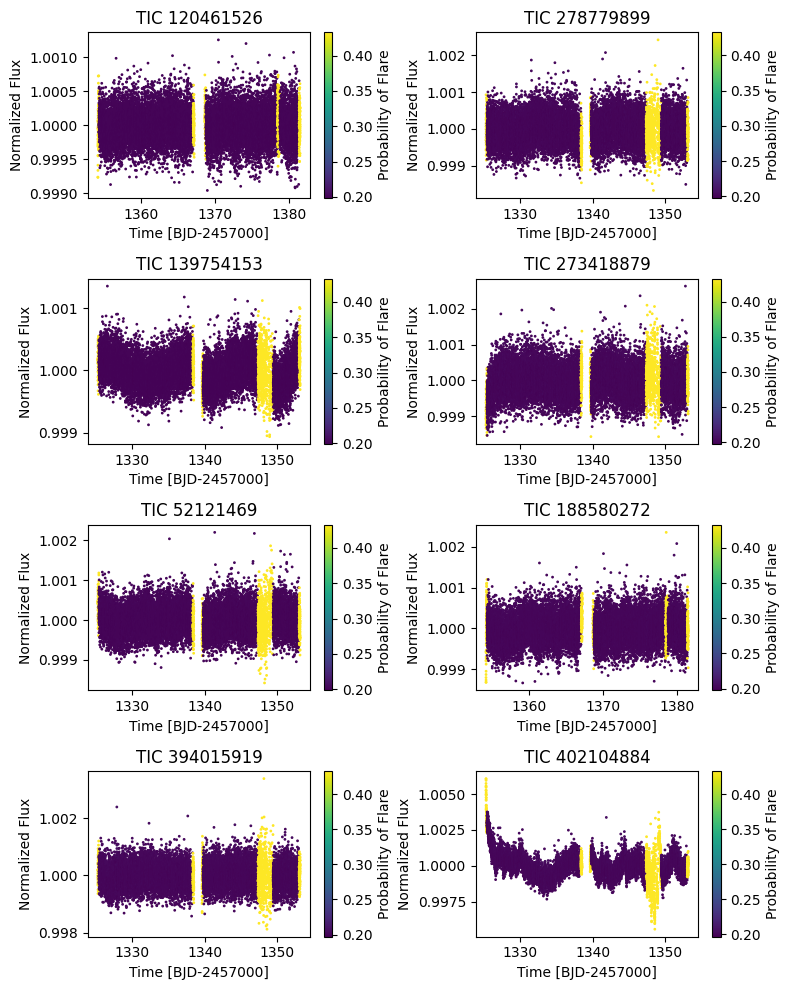

In [16]:
fig = plt.figure(0, [8, 10])

for i, lc in enumerate(lcs):
    # pull out on the first light curve in each set, if more than one exist
    if len(lc) > 0: 
        lc = lc[0]
        
    # predict the flare probability light cuvey for the input data using `stella` 
    # (which applies the necessary pre-processing to the data for input to the CNN)
    time, flux, err, preds = stella_predict(cnn_file, time=lc.time.value, flux=lc.flux, err=lc.flux_err)
    # print(np.shape(lc.time.value), np.shape(preds))
                   
    ax = fig.add_subplot(4, 2, i+1)
    im = ax.scatter(time, flux, c=preds, s=1.)
    
    plt.colorbar(im, ax=ax, label='Probability of Flare')
    ax.set_xlabel('Time [BJD-2457000]')
    ax.set_ylabel('Normalized Flux')
    ax.set_title('TIC {}'.format(lc.targetid))
plt.tight_layout()
plt.show()

## FAQ

- **Why does the data near gaps have a high probability of being flares?**
This isn't necessarily the case.
The issue here is that `stella` needs 100 data points on either side of a given cadence to create an "example" (those 200 cadence samples we trained on).
When there's a gap in the data, the first 100 points can't be centered in each example properly.
As such, `stella` cannot accurately predict flares in these data and skips it.


- **But what if there are flares near the data gaps?**
There may very well be flares towards the data gaps!
Unfortunately, `stella` cannot find those for you at present, and you'll need to identify those yourself.

## Citations

If you use this CNN, `stella`, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the CNN](https://ui.adsabs.harvard.edu/abs/2020AJ....160..219F/abstract)
* [Citing `stella`](https://ui.adsabs.harvard.edu/abs/2020JOSS....5.2347F/abstract)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)



[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 